In [ ]:
%pip install ipython
%pip install numpy
%pip install pandas
%pip install nbformat
%pip install statsmodels
%pip install mlforecast
%pip install lightgbm
%pip install sktime
%pip install scikit-learn
%pip install matplotlib
%pip install plotly
%pip install holidays

%pip install tensorflow
%pip install tensorboard

In [1]:
import re
import os
import math
import datetime

import numpy as np
import pandas as pd

import holidays
th_holidays = holidays.TH()
from IPython.display import clear_output

# Visualization
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
pd.options.plotting.backend = "plotly"
import matplotlib.pyplot as plt

# Data
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from sktime.transformations.series.outlier_detection import HampelFilter
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_log_error

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

# Modeling
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from mlforecast import MLForecast
from lightgbm import LGBMRegressor

import tensorflow as tf
physical_device = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_device[0],True)

from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, Flatten, Input, concatenate
from keras.models import load_model

In [2]:
# Helper functions
def if_work_day(date):
    if ((date in th_holidays) or (date.weekday()>=5)):
        return 0
    else: return 1
    
def reshape_ts_X(input_vector, time_steps, batch_size=None):
    x = np.lib.stride_tricks.sliding_window_view(input_vector[:-1], 
            window_shape=(time_steps, *input_vector.shape[1:]))
    x = x.reshape(-1, time_steps, *input_vector.shape[1:]) # removes extra dimension
    if (batch_size is not None) and (batch_size > 1):
        x = np.array_split(x, len(x) // batch_size)
    # else: x = x[np.newaxis, :, :] 
    return x

def reshape_ts_Y(target_vector, time_steps, batch_size=None):
    y = target_vector[time_steps:]
    if (batch_size is not None) and (batch_size > 1):
        y = np.array_split(y, len(y) // batch_size)
    # else: y = y[np.newaxis, :]
    return y


stats = pd.DataFrame(columns=['RMSE','MAE','MAPE','EV','RMSLE'])
def get_prediction_stats(actual, prediction, model_name='Model'):
    weekly_pred = np.array([actual, prediction]).T.reshape(-1, 7, 2).sum(axis=1)
    weekly_df = pd.DataFrame(weekly_pred)
    weekly_df.columns = ['Actual', 'Prediction']
    
    return pd.DataFrame(
        {
            'RMSE': math.sqrt(mean_squared_error(actual, prediction)),
            'MAE':  mean_absolute_error(actual, prediction),
            'MAPE': mean_absolute_percentage_error(actual, prediction),
            'EV': explained_variance_score(actual, prediction),
            'RMSLE': math.sqrt(mean_squared_log_error(actual, prediction)),
            'MW%D': ((weekly_df['Actual'] - weekly_df['Prediction'])/weekly_df['Actual']*100).mean()
        }, index=[model_name]
    )
    
def mark_days_on_plot(fig, days):
    for day in days:
        fig.add_vrect(
            x0=day - datetime.timedelta(hours=12),
            x1=day + datetime.timedelta(hours=12),
            fillcolor="#582156",
            opacity=0.08,
            line_width=0,
        )
    fig.add_annotation(dict(
        font=dict(size=15),
        x=0,
        y=1.1,
        showarrow=False,
        text="Столбцами отмечены нерабочие дни",
        textangle=0,
        xanchor='left',
        xref="paper",
        yref="paper"))
    return fig

In [3]:
# Presentation theme

pio.templates["custom"] = go.layout.Template(
    layout=go.Layout(
        colorway=['#385E88', '#EC008C', '#224E7F', '#AA2070', '#582156'],
        plot_bgcolor='#F8F0E3',
        paper_bgcolor='#F8F0E3'
    )
)
pio.templates.default = 'custom'

# Paper theme

# grayscale_template = {
#     "layout": {
#         "paper_bgcolor": "white",  # Background color
#         "plot_bgcolor": "white",   # Plot background color
#         "font": {
#             "color": "black"  # Text color
#         },
#         "xaxis": {
#             "linecolor": "black",  # X-axis line color
#             "gridcolor": "lightgray",  # X-axis grid color
#             "zerolinecolor": "gray"    # X-axis zero line color
#         },
#         "yaxis": {
#             "linecolor": "black",  # Y-axis line color
#             "gridcolor": "lightgray",  # Y-axis grid color
#             "zerolinecolor": "gray"    # Y-axis zero line color
#         }
#     }
# }

# # Set the default template to the grayscale template
# pio.templates["grayscale"] = grayscale_template
# pio.templates.default = "grayscale"

In [4]:
# Dataset concatenation
# df_2018 = pd.DataFrame()
# for i_floor in range(7):
#     df = pd.read_csv(f'split_collection/2018Floor{i_floor+1}.csv', parse_dates=['Date'], 
#                    date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S")).set_index('Date')
#     print(f"2018Floor{i_floor+1}", df.shape)
#     df_2018 = pd.concat([df_2018, df], axis=1)
    
# df_2019 = pd.DataFrame()
# for i_floor in range(7):
#     df = pd.read_csv(f'split_collection/2019Floor{i_floor+1}.csv', parse_dates=['Date'], 
#                    date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S")).set_index('Date')
#     print(f"2019Floor{i_floor+1} ", df.shape)
#     df_2019 = pd.concat([df_2019, df], axis=1)
# concatenated_df = pd.concat([df_2018, df_2019]).filter(like='(kW)')

# Clean up

# merged_df = pd.read_csv('merged_load_dataset.csv', parse_dates = ['Date']).set_index('Date')

# merged_df[merged_df > 200] = None
# merged_df = merged_df.ffill(limit=60)

# def fill_gaps_with_monthly_avg(series):
#     monthly_avg = series.resample('M').mean()
#     series_filled = series.combine_first(monthly_avg.reindex(series.index))
#     # If there are still NaN values, fill them with the overall mean of the series
#     series_filled = series_filled.fillna(series.mean())
#     return series_filled

# merged_df = merged_df.apply(fill_gaps_with_monthly_avg)

# merged_df = merged_df.resample('H').mean()

# not_ac_columns = [column for column in merged_df.columns if 'AC' not in column]
# transformer = HampelFilter(window_length=12, n_sigma=80) 
# merged_df[not_ac_columns] = transformer.fit_transform(merged_df[not_ac_columns])

# merged_df = merged_df.ffill(limit=12).bfill(limit=12)

# merged_df

In [5]:
merged_df = pd.read_csv('data/clean_merged_dataset.csv',parse_dates = ['Date']).set_index('Date')

# Combine by type (Light, Plug, AC)
merged_df.columns = [re.sub(r"\d+$", "", column) for column in merged_df.columns]
merged_df = merged_df.groupby(by=merged_df.columns, axis=1).sum()

tuple_columns = [(x[0][-1], x[1][-1], x[2]) for x in [column.split('_') for column in merged_df.columns]]
merged_df.columns = pd.MultiIndex.from_tuples(tuple_columns, names=['Floor', 'Zone','Sensor'])


merged_df = merged_df.resample('D').sum() 
merged_df = merged_df.iloc[:-2] # For clean weeks in testing


total_load_df = merged_df.sum(axis=1)
total_by_zone_df = merged_df.groupby(level=1, axis = 1).sum()
total_by_type_df = merged_df.groupby(level=2, axis = 1).sum()

test_len = 7*37

if_work_day_ts = pd.Series(total_load_df.index.map(if_work_day), index=total_load_df.index)
off_days = if_work_day_ts[-test_len:][if_work_day_ts[-test_len:] == 0].index # For plots

load_train_ts = total_load_df[:-test_len]
load_test_ts = total_load_df[-test_len:]
predictions_df = pd.DataFrame(load_test_ts, columns=["Actual"])

### Total Load

In [7]:
fig = px.line(total_load_df.rolling(7).mean())
fig.update(layout_showlegend=False)
fig.update_layout(xaxis_title="Дата",
                  yaxis_title="Потребление (Вт⋅ч)")
fig.update_xaxes(
    dtick="M1",   # display x-ticks every month
    tickformat="%m-%Y"  # date format
) 
fig

In [34]:
import plotly.graph_objects as go
lags = 30
df_acf = acf(total_load_df, nlags=30)
df_pacf = pacf(total_load_df, nlags=30)
fig = go.Figure()
fig.add_trace(go.Scatter(
    x= np.arange(len(df_acf)),
    y= df_acf,
    name= 'Автокорреляция',
    ))
fig.add_trace(go.Scatter(
    x= np.arange(len(df_pacf)),
    y= df_pacf,
    name= 'Частичная Автокорреляция',
    ))
fig.update_layout(
    title="Автокорреляция",
    xaxis_title="Лаг",
    height=500,
    xaxis=dict(tickmode='linear',dtick=1),
    yaxis=dict(tickmode='linear',dtick=0.1)
    )
fig.show()

#### Stationarity

In [9]:
results_df = pd.DataFrame(columns=['Statistic', 'p-value', 'Result'])
result = sm.tsa.stattools.adfuller(total_load_df)
results_df.loc['ADF',:] = pd.Series({
    'Statistic': result[0],'p-value': result[1],
    'Result': "stationary" if result[1] < 0.05 else "non-stationary"})

result = sm.tsa.stattools.kpss(total_load_df)
results_df.loc['KPSS',:] = pd.Series({
    'Statistic': result[0],'p-value': result[1],
    'Result': "stationary" if result[1] > 0.05 else "non-stationary"})
results_df

,Statistic,p-value,Result
ADF,-4.136509,0.000842,stationary
KPSS,0.456699,0.052716,stationary


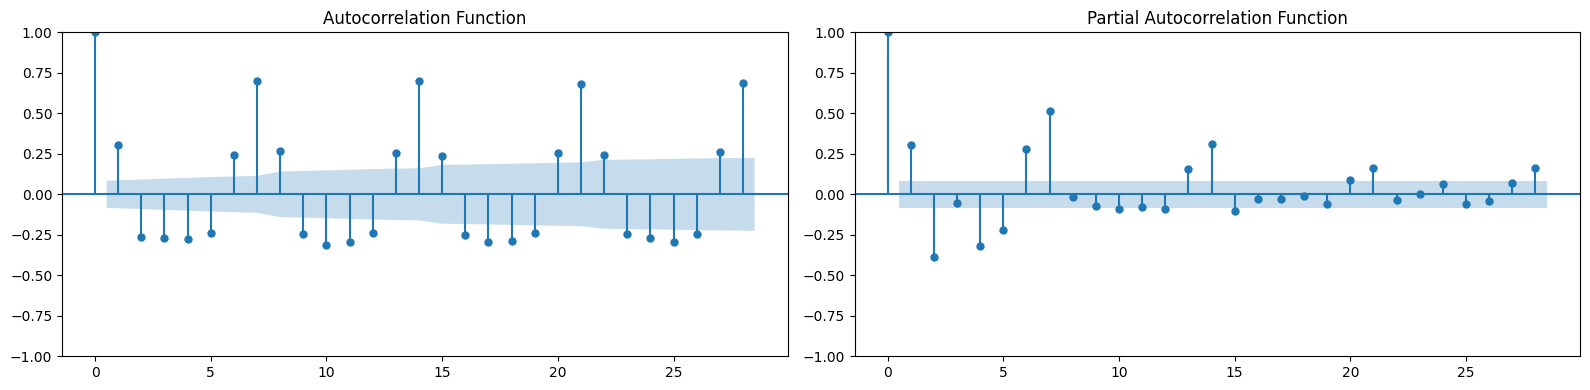

In [10]:
lags = 28

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(total_load_df, lags=lags, ax=axes[0])
axes[0].set_title('Autocorrelation Function')

plot_pacf(total_load_df, lags=lags, ax=axes[1],method='ywm')
axes[1].set_title('Partial Autocorrelation Function')

plt.tight_layout() 
plt.show()

#### Models

##### ARIMA

In [11]:
history = load_train_ts.to_list()
predictions = []

for t_week in range(int(len(load_test_ts) / 7)):
    model = ARIMA(history, order=(14,0,14))
    model_fit = model.fit()
    
    next_pred = model_fit.forecast(steps=7).tolist()
    predictions += next_pred
    history += load_test_ts[t_week*7:(t_week+1)*7].tolist()
    clear_output(wait=False)
predictions_df["ARIMA-Total"] = predictions

In [29]:
model_stats_df = get_prediction_stats(predictions_df["Actual"], predictions_df["ARIMA-Total"], 'ARIMA-Total')
stats = stats.append(model_stats_df)

fig = px.line(predictions_df[["Actual", "ARIMA-Total"]])
fig.update_layout(xaxis_title="Дата",
                  yaxis_title="Потребление (Вт⋅ч)",
                  legend_title=None)
fig.update_xaxes(dtick="M1", tickformat="%m-%Y") 

print(model_stats_df)
fig

                    RMSE        MAE      MAPE        EV     RMSLE    % Diff
ARIMA-Total  1275.906037  825.25448  0.182386  0.638208  0.253747 -0.624453


##### SARIMAX

In [24]:
history = load_train_ts.to_list()
predictions = []

for t_week in range(int(len(load_test_ts) / 7)):
    model = SARIMAX(history, exog=if_work_day_ts[:len(history)], order=(14,2,14))
    model_fit = model.fit()
    
    next_pred = model_fit.forecast(steps=7, exog=if_work_day_ts[len(history):len(history)+7]).tolist()
    next_pred = [val if val > min(history) else min(history) for val in next_pred]
    predictions += next_pred
    history += load_test_ts[t_week*7:(t_week+1)*7].tolist()
    clear_output(wait=False)
predictions_df["SARIMAX-Total"] = predictions

In [46]:
model_stats_df = get_prediction_stats(predictions_df["Actual"], predictions_df["SARIMAX-Total"], 'SARIMAX-Total')
stats = stats.append(model_stats_df)

fig = px.line(predictions_df[["Actual", "SARIMAX-Total"]])
fig.update_layout(xaxis_title="Дата",
                  yaxis_title="Потребление (Вт⋅ч)",
                  legend_title=None)
fig.update_xaxes(dtick="M1", tickformat="%m-%Y") 

print(model_stats_df)
mark_days_on_plot(fig, off_days)

                     RMSE         MAE      MAPE        EV     RMSLE    % Diff
SARIMAX-Total  771.029446  543.614301  0.108719  0.867768  0.155778  0.019482


##### Lightgbm

In [30]:
data = pd.DataFrame(total_load_df).reset_index()
data['Unique Id'] = 'Total Load'
data.columns = ['Date', 'Total Load', 'Unique Id']

data['If Work Day'] = data['Date'].map(if_work_day)

train = data.iloc[:-test_len]
test = data.iloc[-test_len:]

history = train
predictions = pd.DataFrame([], columns=['Unique Id','Date','LGBMRegressor'])

for t_week in range(int(len(load_test_ts) / 7)):
    models = [LGBMRegressor(random_state=0, n_estimators=500)]

    model = MLForecast(models=models,
                    freq='D',
                    lags=[1,2,4,5,6,7,14,15,20,21,28],
                    num_threads=14)
    
    model.fit(history, id_col='Unique Id', time_col='Date', target_col='Total Load', static_features=[])
    
    next_pred = model.predict(horizon=7, dynamic_dfs=[test[['Date', 'Unique Id', 'If Work Day']]])
    
    predictions = predictions.append(next_pred)
    history = history.append(test.iloc[t_week*7:(t_week+1)*7, :])
    clear_output(wait=False)
    
predictions = predictions.merge(test[['Unique Id', 'Date', 'Total Load', 'If Work Day']], on=['Unique Id', 'Date'], how='left')
predictions_df["LightGBM-Total"] = predictions['LGBMRegressor'].to_numpy()

In [38]:
model_stats_df = get_prediction_stats(predictions_df["Actual"], predictions_df["LightGBM-Total"], 'LightGBM-Total')
stats = stats.append(model_stats_df)

fig = px.line(predictions_df[["Actual", "LightGBM-Total"]])
fig.update_layout(xaxis_title="Дата",
                  yaxis_title="Потребление (Вт⋅ч)",
                  legend_title=None)
fig.update_xaxes(dtick="M1", tickformat="%m-%Y") 

print(model_stats_df)
mark_days_on_plot(fig, off_days)

                      RMSE         MAE      MAPE       EV     RMSLE    % Diff
LightGBM-Total  824.804927  601.511208  0.120255  0.84868  0.167254 -0.041597


### Load by zone

In [59]:
fig = px.line(total_by_zone_df.rolling(7).mean())
fig.update_layout(xaxis_title="Дата",
                  yaxis_title="Потребление (Вт⋅ч)")
fig.update_xaxes(dtick="M1", tickformat="%m-%Y") 
fig

##### Stationarity

In [42]:
results_df = pd.DataFrame(columns=['Test', 'Zone', 'Statistic', 'p-value', 'Result'])
for column in total_by_zone_df.columns:
    result = sm.tsa.stattools.adfuller(total_by_zone_df[column])
    results_df = results_df.append({
        'Test': 'ADF',
        'Zone': column,
        'Statistic': result[0],
        'p-value': result[1],
        'Result': "stationary" if result[1] < 0.05 else "non-stationary"
    }, ignore_index=True)
    
    result = sm.tsa.stattools.kpss(total_load_df)
    results_df = results_df.append({
        'Test': 'KPSS',
        'Zone': column,
        'Statistic': result[0],
        'p-value': result[1],
        'Result': "stationary" if result[1] > 0.05 else "non-stationary"
    }, ignore_index=True)
results_df.set_index(['Test', 'Zone'], drop=True).unstack(level=0).swaplevel(axis=1).sort_index(axis=1)

Test         ADF                            KPSS                    
          Result Statistic   p-value      Result Statistic   p-value
Zone                                                                
1     stationary -3.570070  0.006360  stationary  0.456699  0.052716
2     stationary -3.281527  0.015725  stationary  0.456699  0.052716
3     stationary -4.173678  0.000730  stationary  0.456699  0.052716
4     stationary -5.189376  0.000009  stationary  0.456699  0.052716
5     stationary -5.390252  0.000004  stationary  0.456699  0.052716

c:\dev\Projects\load-prediction-research-notebook\.venv\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



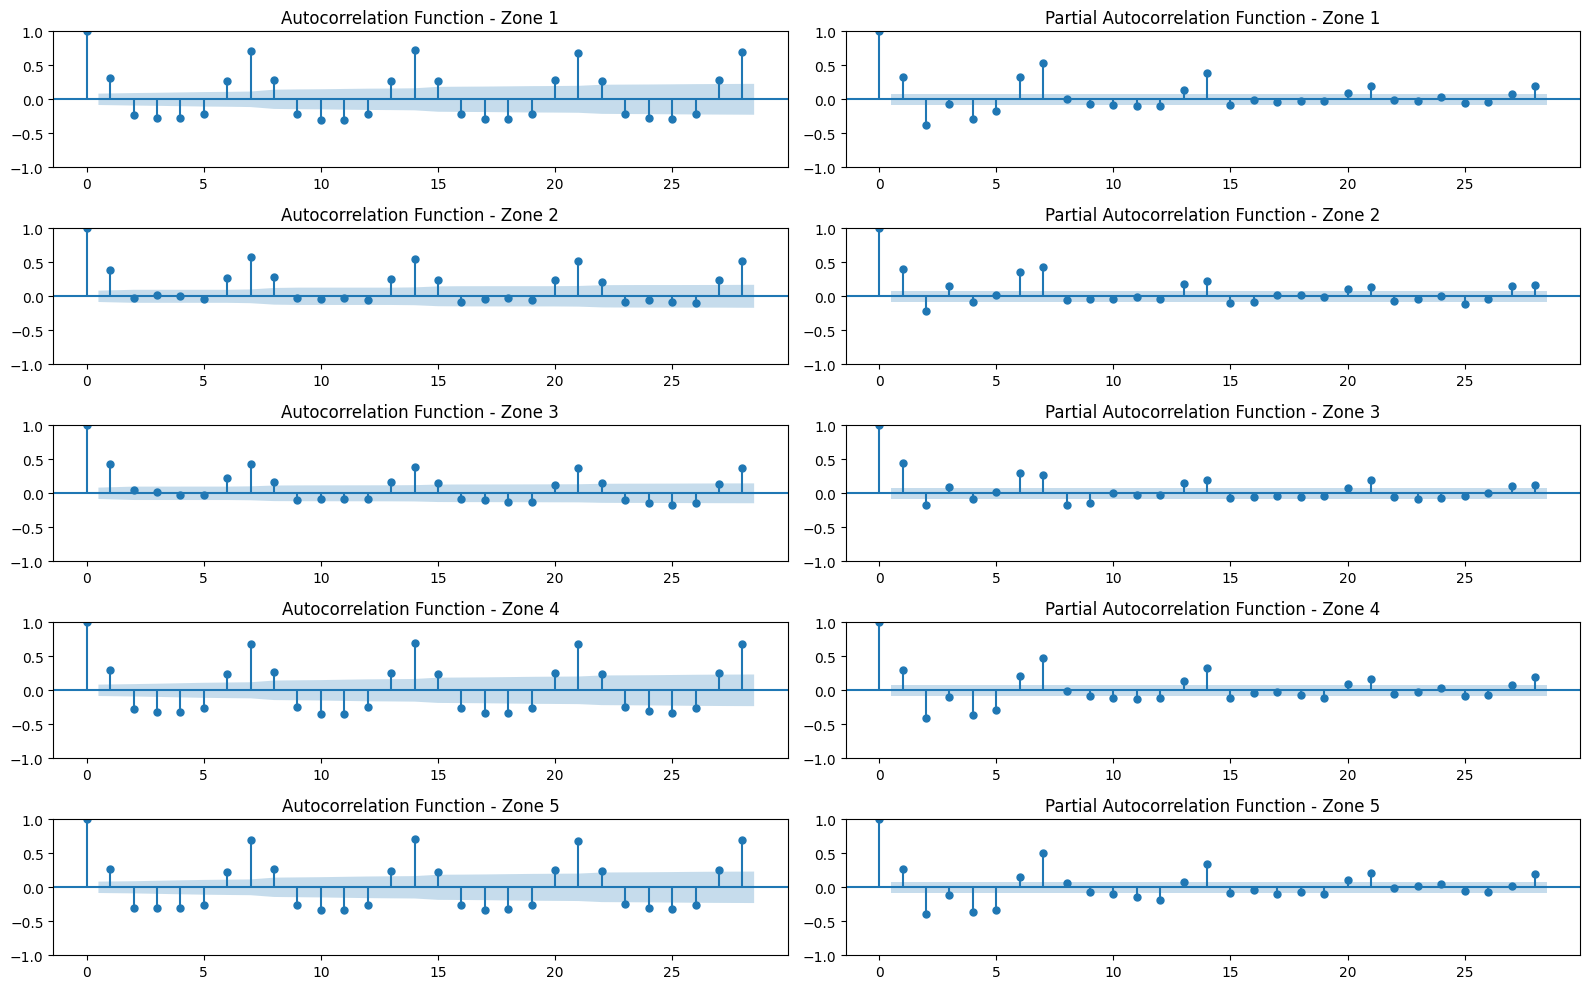

In [43]:
lags = 28
fig, axes = plt.subplots(5, 2, figsize=(16, 10))

for i, column_name in enumerate(total_by_zone_df.columns): 
    plot_acf(total_by_zone_df[column_name], lags=lags, ax=axes[i, 0])
    axes[i, 0].set_title(f'Autocorrelation Function - Zone {column_name}')

    plot_pacf(total_by_zone_df[column_name], lags=lags, ax=axes[i, 1])
    axes[i, 1].set_title(f'Partial Autocorrelation Function - Zone {column_name}')

plt.tight_layout()
plt.show()

#### Models

In [44]:
zone_train_df = total_by_zone_df[:-test_len]
zone_test_df = total_by_zone_df[-test_len:]

##### ARIMA

In [45]:
predictions = []
for col in zone_train_df.columns:
    history = zone_train_df[col].to_list()
    prediction = []
    for t_week in range(int(len(zone_test_df[col]) / 7)):
        model = ARIMA(history, order=(14,1,14))
        model_fit = model.fit()
        
        next_pred = model_fit.forecast(steps=7).tolist()
        prediction += next_pred
        history += zone_test_df[col][t_week*7:(t_week+1)*7].tolist()
        clear_output(wait=False)
    predictions.append(prediction)

predictions_arima_zone = pd.DataFrame(predictions).T
predictions_arima_zone.columns = zone_train_df.columns
predictions_df["ARIMA-Zone"] = predictions_arima_zone.sum(axis=1).to_numpy()

In [55]:
model_stats_df = get_prediction_stats(predictions_df["Actual"], predictions_df["ARIMA-Zone"], 'ARIMA-Zone')
stats = stats.append(model_stats_df)

fig = px.line(predictions_df[["Actual", "ARIMA-Zone"]])
fig.update_layout(xaxis_title="Дата",
                  yaxis_title="Потребление (Вт⋅ч)",
                  legend_title=None)
fig.update_xaxes(dtick="M1", tickformat="%m-%Y") 

print(model_stats_df)
fig

                  RMSE         MAE      MAPE        EV     RMSLE    % Diff
ARIMA-Zone  1218.66458  798.390735  0.177047  0.669663  0.246055 -0.085828


In [57]:
fig = make_subplots(rows=predictions_arima_zone.shape[1], cols=1, 
                    shared_xaxes=True, vertical_spacing=0.03,
                    subplot_titles = [f'Zone {col}' for col in predictions_arima_zone.columns])

for i, col in enumerate(predictions_arima_zone.columns):
    fig.add_trace(
    go.Scatter(x=zone_test_df.index, y=predictions_arima_zone[col], 
               name=f'Zone {col}: Pred', line_color='#385E88',
               mode='lines'),
    row=i+1, col=1)
    fig.add_trace(
    go.Scatter(x=zone_test_df.index, y=zone_test_df[col], 
               name=f'Zone {col}: Actual', line_color='#EC008C',
               mode='lines'),
    row=i+1, col=1)
fig.update_layout(
    height=1000,)
fig.show()

##### SARIMAX

In [ ]:
predictions = []
for col in zone_train_df.columns:
    history = zone_train_df[col].to_list()
    if_work_day_ts = total_load_df.index.map(if_work_day)
    prediction = []
    for t_week in range(int(len(zone_test_df[col]) / 7)):
        model = SARIMAX(history, exog=if_work_day_ts[:len(history)], order=(14,1,14))
        model_fit = model.fit()
        
        next_pred = model_fit.forecast(steps=7, exog=if_work_day_ts[len(history):len(history)+7]).tolist()
        next_pred = [val if val > min(history) else min(history) for val in next_pred]
        prediction += next_pred
        history += zone_test_df[col][t_week*7:(t_week+1)*7].tolist()
        clear_output(wait=False)
    predictions.append(prediction)

predictions_sarimax_zone = pd.DataFrame(predictions).T
predictions_sarimax_zone.columns = zone_train_df.columns
predictions_df["SARIMAX-Zone"] = predictions_sarimax_zone.sum(axis=1).to_numpy()

In [65]:
model_stats_df = get_prediction_stats(predictions_df["Actual"], predictions_df["SARIMAX-Zone"], 'SARIMAX-Zone')
stats = stats.append(model_stats_df)

fig = px.line(predictions_df[["Actual", "SARIMAX-Zone"]])
fig.update_layout(xaxis_title="Дата",
                  yaxis_title="Потребление (Вт⋅ч)",
                  legend_title=None)
fig.update_xaxes(dtick="M1", tickformat="%m-%Y") 

print(model_stats_df)
mark_days_on_plot(fig, off_days)

                   RMSE        MAE      MAPE        EV     RMSLE    % Diff
SARIMAX-Zone  756.26665  529.46585  0.101943  0.873054  0.150311  0.581577


In [67]:
fig = make_subplots(rows=predictions_sarimax_zone.shape[1], cols=1, 
                    shared_xaxes=True, vertical_spacing=0.03,
                    subplot_titles = [f'Zone {col}' for col in predictions_sarimax_zone.columns])

for i, col in enumerate(predictions_sarimax_zone.columns):
    fig.add_trace(
    go.Scatter(x=zone_test_df.index, y=predictions_sarimax_zone[col], 
               name=f'Zone {col}: Pred', line_color='#385E88',
               mode='lines'),
    row=i+1, col=1)
    fig.add_trace(
    go.Scatter(x=zone_test_df.index, y=zone_test_df[col], 
               name=f'Zone {col}: Actual', line_color='#EC008C',
               mode='lines'),
    row=i+1, col=1)
fig.update_layout(
    height=1000,)
fig.update_layout(plot_bgcolor='#F8F0E3',
                  paper_bgcolor='#F8F0E3')
fig.update_xaxes(showline=False, linewidth=2, gridcolor='#D5D2DA', zerolinecolor='#D5D2DA')
fig.update_yaxes(showline=False, linewidth=2, gridcolor='#D5D2DA', zerolinecolor='#D5D2DA')
mark_days_on_plot(fig, off_days)

##### Lightgbm

In [76]:
data = total_by_zone_df.reset_index()

train = data.iloc[:-test_len]
test = data.iloc[-test_len:]

train = pd.wide_to_long(train, 
                       stubnames='', i=['Date'], j='Unique Id').reset_index()
train.columns = ['Date', 'Unique Id', 'Load']
train['If Work Day'] = train['Date'].map(if_work_day)


test = pd.wide_to_long(test, 
                       stubnames='', i=['Date'], j='Unique Id').reset_index()
test.columns = ['Date', 'Unique Id', 'Load']
test['If Work Day'] = test['Date'].map(if_work_day)

In [83]:
history = train
predictions = pd.DataFrame([], columns=['Unique Id','Date','LGBMRegressor'])

for t_week in range(int(len(load_test_ts) / 7)):
    models = [LGBMRegressor(random_state=0, n_estimators=500)]

    model = MLForecast(models=models,
                    freq='D',
                    lags=[1,2,4,5,6,7,8,9,12,13,14,21,28],
                    num_threads=14)
    
    model.fit(history, id_col='Unique Id', time_col='Date', target_col='Load', static_features=[])
    
    next_pred = model.predict(horizon=7, dynamic_dfs=[test[['Date', 'Unique Id', 'If Work Day']]])
    
    predictions = predictions.append(next_pred)
    history = history.append(test[test['Date'].isin(next_pred['Date'].unique())])
    clear_output(wait=False)
    
predictions = predictions.merge(test[['Unique Id', 'Date', 'Load', 'If Work Day']], 
                                on=['Unique Id', 'Date'], how='left')
predictions = predictions.reset_index()

predictions_df["LightGBM-Zone"] = predictions[['Date','LGBMRegressor']].groupby(['Date']).sum()
predictions_lightgbm_zone = predictions.pivot(index='Date', columns='Unique Id', values='LGBMRegressor')
predictions_lightgbm_zone.columns = predictions_lightgbm_zone.columns.map(str)

In [85]:
model_stats_df = get_prediction_stats(predictions_df["Actual"], predictions_df["LightGBM-Zone"], 'LightGBM-Zone')
stats = stats.append(model_stats_df)

fig = px.line(predictions_df[["Actual", "LightGBM-Zone"]])
fig.update_layout(xaxis_title="Дата",
                  yaxis_title="Потребление (Вт⋅ч)",
                  legend_title=None)
fig.update_xaxes(dtick="M1", tickformat="%m-%Y") 

print(model_stats_df)
mark_days_on_plot(fig, off_days)

                     RMSE         MAE      MAPE        EV    RMSLE    % Diff
LightGBM-Zone  727.561252  556.645077  0.111899  0.882278  0.15223 -0.163674


In [92]:
fig = make_subplots(rows=predictions_lightgbm_zone.shape[1], cols=1, 
                    shared_xaxes=True, vertical_spacing=0.03,
                    subplot_titles = [f'Zone {col}' for col in predictions_lightgbm_zone.columns])

for i, col in enumerate(predictions_lightgbm_zone.columns):
    fig.add_trace(
    go.Scatter(x=zone_test_df.index, y=predictions_lightgbm_zone[col], 
               name=f'Zone {col}: Pred', line_color='#385E88',
               mode='lines'),
    row=i+1, col=1)
    fig.add_trace(
    go.Scatter(x=zone_test_df.index, y=zone_test_df[col], 
               name=f'Zone {col}: Actual', line_color='#EC008C',
               mode='lines'),
    row=i+1, col=1)
fig.update_layout(
    height=1000,)
fig.update_layout(plot_bgcolor='#F8F0E3',
                  paper_bgcolor='#F8F0E3')
fig.update_xaxes(showline=False, linewidth=2, gridcolor='#D5D2DA', zerolinecolor='#D5D2DA')
fig.update_yaxes(showline=False, linewidth=2, gridcolor='#D5D2DA', zerolinecolor='#D5D2DA')
mark_days_on_plot(fig, off_days)

### Load by type

In [89]:
fig = px.line(total_by_type_df.rolling(7).mean())
fig.update_layout(xaxis_title="Дата",
                  yaxis_title="Потребление (Вт⋅ч)")
fig.update_xaxes(
    dtick="M1",   # display x-ticks every month
    tickformat="%m-%Y"  # date format
) 
fig

##### Stationarity

In [32]:
results_df = pd.DataFrame(columns=['Test', 'Type', 'Statistic', 'p-value', 'Result'])
for column in total_by_type_df.columns:
    result = sm.tsa.stattools.adfuller(total_by_type_df[column])
    results_df = results_df.append({
        'Test': 'ADF',
        'Type': column,
        'Statistic': result[0],
        'p-value': result[1],
        'Result': "stationary" if result[1] < 0.05 else "non-stationary"
    }, ignore_index=True)
    
    result = sm.tsa.stattools.kpss(total_load_df)
    results_df = results_df.append({
        'Test': 'KPSS',
        'Type': column,
        'Statistic': result[0],
        'p-value': result[1],
        'Result': "stationary" if result[1] > 0.05 else "non-stationary"
    }, ignore_index=True)
results_df.set_index(['Test', 'Type'], drop=True).unstack(level=0).swaplevel(axis=1).sort_index(axis=1)

Test              ADF                            KPSS                    
               Result Statistic   p-value      Result Statistic   p-value
Type                                                                     
AC         stationary -3.276702  0.015953  stationary  0.456699  0.052716
Light      stationary -3.143422  0.023502  stationary  0.456699  0.052716
Plug   non-stationary -2.613503  0.090238  stationary  0.456699  0.052716

c:\dev\Projects\load-prediction-research-notebook\.venv\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



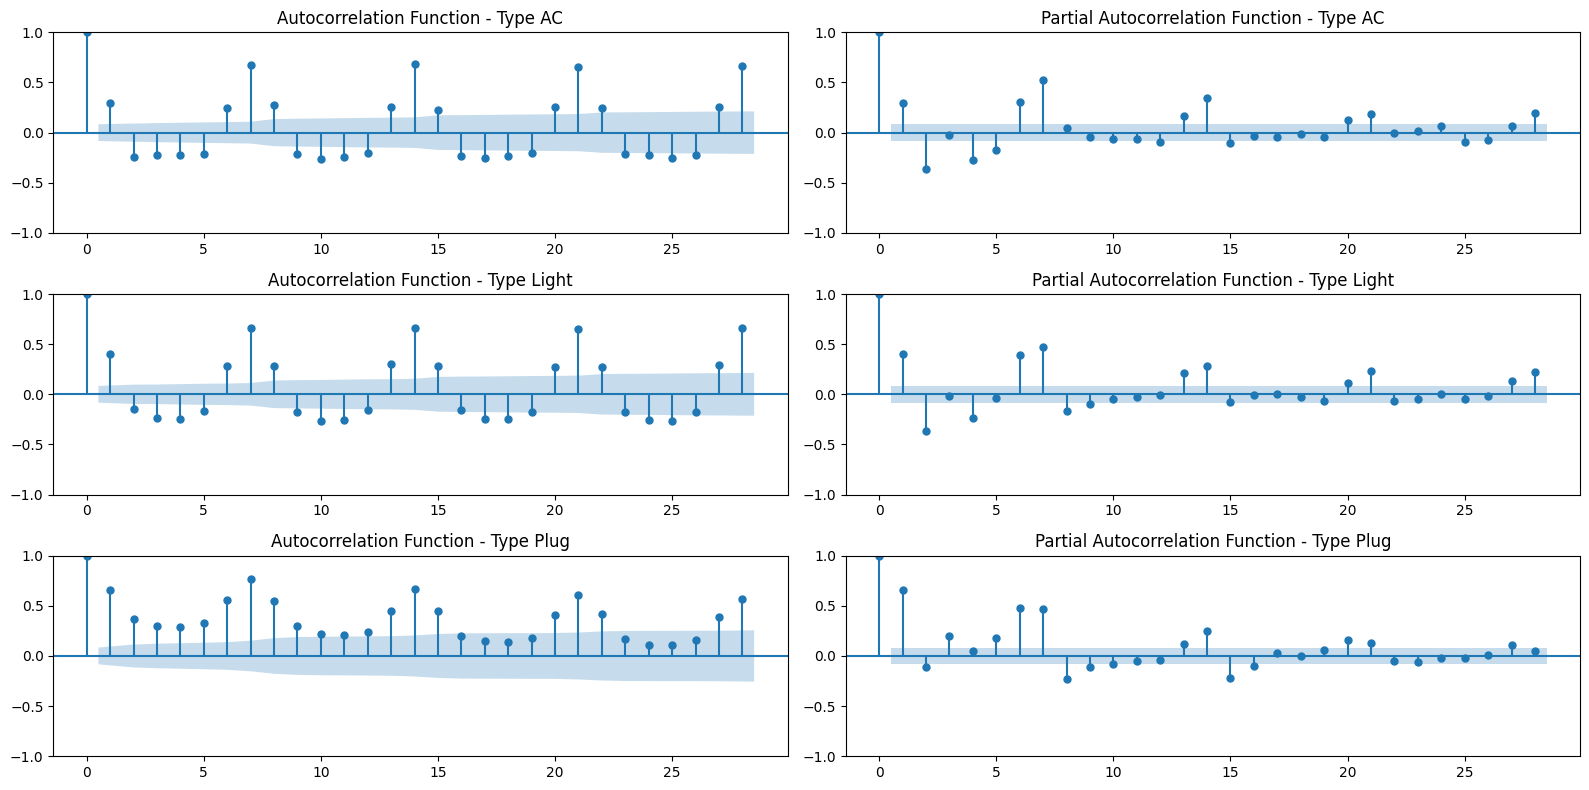

In [33]:
lags = 28
fig, axes = plt.subplots(3, 2, figsize=(16, 8))

for i, column_name in enumerate(total_by_type_df.columns): 
    plot_acf(total_by_type_df[column_name], lags=lags, ax=axes[i, 0])
    axes[i, 0].set_title(f'Autocorrelation Function - Type {column_name}')

    plot_pacf(total_by_type_df[column_name], lags=lags, ax=axes[i, 1])
    axes[i, 1].set_title(f'Partial Autocorrelation Function - Type {column_name}')

plt.tight_layout()
plt.show()

#### Models

In [94]:
type_train_df = total_by_type_df[:-test_len]
type_test_df = total_by_type_df[-test_len:]

##### ARIMA

In [95]:
predictions = []
for col in type_train_df.columns:
    history = type_train_df[col].to_list()
    prediction = []
    for t_week in range(int(len(type_test_df[col]) / 7)):
        model = ARIMA(history, order=(14,1,14))
        model_fit = model.fit()
        
        next_pred = model_fit.forecast(steps=7).tolist()
        prediction += next_pred
        history += type_test_df[col][t_week*7:(t_week+1)*7].tolist()
        clear_output(wait=False)
    predictions.append(prediction)

predictions_arima_type = pd.DataFrame(predictions).T
predictions_arima_type.columns = type_train_df.columns
predictions_df["ARIMA-Type"] = predictions_arima_zone.sum(axis=1).to_numpy()

In [105]:
model_stats_df = get_prediction_stats(predictions_df["Actual"], predictions_df["ARIMA-Type"], 'ARIMA-Type')
stats = stats.append(model_stats_df)

fig = px.line(predictions_df[["Actual", "ARIMA-Type"]])
fig.update_layout(xaxis_title="Дата",
                  yaxis_title="Потребление (Вт⋅ч)",
                  legend_title=None)
fig.update_xaxes(dtick="M1", tickformat="%m-%Y") 

print(model_stats_df)
fig

                  RMSE         MAE      MAPE        EV     RMSLE    % Diff
ARIMA-Type  1218.66458  798.390735  0.177047  0.669663  0.246055 -0.085828


In [107]:
fig = make_subplots(rows=predictions_arima_type.shape[1], cols=1, 
                    shared_xaxes=True, vertical_spacing=0.03,
                    subplot_titles = [f'Type {col}' for col in predictions_arima_type.columns])

for i, col in enumerate(predictions_arima_type.columns):
    fig.add_trace(
    go.Scatter(x=type_test_df.index, y=predictions_arima_type[col], 
               name=f'Type {col}: Pred', line_color='#385E88',
               mode='lines'),
    row=i+1, col=1)
    fig.add_trace(
    go.Scatter(x=type_test_df.index, y=type_test_df[col], 
               name=f'Type {col}: Actual', line_color='#EC008C',
               mode='lines'),
    row=i+1, col=1)
fig.update_layout(
    height=1000,)
fig.update_layout(plot_bgcolor='#F8F0E3',
                  paper_bgcolor='#F8F0E3')
fig.update_xaxes(showline=False, linewidth=2, gridcolor='#D5D2DA', zerolinecolor='#D5D2DA')
fig.update_yaxes(showline=False, linewidth=2, gridcolor='#D5D2DA', zerolinecolor='#D5D2DA')

##### SARIMAX

In [108]:
predictions = []
for col in type_train_df.columns:
    history = type_train_df[col].to_list()
    if_work_day_ts = total_load_df.index.map(if_work_day)
    prediction = []
    for t_week in range(int(len(type_test_df[col]) / 7)):
        model = SARIMAX(history, exog=if_work_day_ts[:len(history)], order=(14,2,14))
        model_fit = model.fit()
        
        next_pred = model_fit.forecast(steps=7, exog=if_work_day_ts[len(history):len(history)+7]).tolist()
        next_pred = [val if val > min(history) else min(history) for val in next_pred]
        prediction += next_pred
        history += type_test_df[col][t_week*7:(t_week+1)*7].tolist()
        clear_output(wait=False)
    predictions.append(prediction)

predictions_sarimax_type = pd.DataFrame(predictions).T
predictions_sarimax_type.columns = type_train_df.columns
predictions_df["SARIMAX-Type"] = predictions_sarimax_type.sum(axis=1).to_numpy()

In [ ]:
predictions_df["Actual"] - predictions_df["SARIMAX-Type"]

In [109]:
model_stats_df = get_prediction_stats(predictions_df["Actual"], predictions_df["SARIMAX-Type"], 'SARIMAX-Type')
stats = stats.append(model_stats_df)

fig = px.line(predictions_df[["Actual", "SARIMAX-Type"]])
fig.update_layout(xaxis_title="Дата",
                  yaxis_title="Потребление (Вт⋅ч)",
                  legend_title=None)
fig.update_xaxes(dtick="M1", tickformat="%m-%Y") 

print(model_stats_df)
mark_days_on_plot(fig, off_days)

                    RMSE         MAE      MAPE        EV     RMSLE    % Diff
SARIMAX-Type  782.416931  547.238391  0.106505  0.864034  0.153587  0.500923


In [111]:
fig = make_subplots(rows=predictions_sarimax_type.shape[1], cols=1, 
                    shared_xaxes=True, vertical_spacing=0.03,
                    subplot_titles = [f'Type {col}' for col in predictions_sarimax_type.columns])

for i, col in enumerate(predictions_sarimax_type.columns):
    fig.add_trace(
    go.Scatter(x=type_test_df.index, y=predictions_sarimax_type[col], 
               name=f'Type {col}: Pred', line_color='#385E88',
               mode='lines'),
    row=i+1, col=1)
    fig.add_trace(
    go.Scatter(x=type_test_df.index, y=type_test_df[col], 
               name=f'Type {col}: Actual', line_color='#EC008C',
               mode='lines'),
    row=i+1, col=1)
fig.update_layout(
    height=1000,)
fig.update_layout(plot_bgcolor='#F8F0E3',
                  paper_bgcolor='#F8F0E3')
fig.update_xaxes(showline=False, linewidth=2, gridcolor='#D5D2DA', zerolinecolor='#D5D2DA')
fig.update_yaxes(showline=False, linewidth=2, gridcolor='#D5D2DA', zerolinecolor='#D5D2DA')
mark_days_on_plot(fig, off_days)

##### Lightgbm

In [112]:
data = total_by_type_df.reset_index()

train = data.iloc[:-test_len]
test = data.iloc[-test_len:]

train = pd.wide_to_long(train, stubnames='', 
                       i=['Date'], j='unique_id', 
                       suffix='(AC|Light|Plug)').reset_index()
train.columns = ['Date', 'Unique Id', 'Load']
train['If Work Day'] = train['Date'].map(if_work_day)


test = pd.wide_to_long(test, stubnames='', 
                       i=['Date'], j='unique_id', 
                       suffix='(AC|Light|Plug)').reset_index()
test.columns = ['Date', 'Unique Id', 'Load']
test['If Work Day'] = test['Date'].map(if_work_day)

In [113]:
history = train
predictions = pd.DataFrame([], columns=['Unique Id','Date','LGBMRegressor'])

for t_week in range(int(len(load_test_ts) / 7)):
    models = [LGBMRegressor(random_state=0, n_estimators=500)]

    model = MLForecast(models=models,
                    freq='D',
                    lags=[1,2,4,5,6,7,8,9,12,13,14,21,28],
                    num_threads=14)
    
    model.fit(history, id_col='Unique Id', time_col='Date', target_col='Load', static_features=[])
    
    next_pred = model.predict(horizon=7, dynamic_dfs=[test[['Date', 'Unique Id', 'If Work Day']]])
    
    predictions = predictions.append(next_pred)
    history = history.append(test[test['Date'].isin(next_pred['Date'].unique())])
    clear_output(wait=False)
    
predictions = predictions.merge(test[['Unique Id', 'Date', 'Load', 'If Work Day']], 
                                on=['Unique Id', 'Date'], how='left')
predictions = predictions.reset_index()

predictions_df["LightGBM-Type"] = predictions[['Date','LGBMRegressor']].groupby(['Date']).sum()
predictions_lightgbm_type = predictions.pivot(index='Date', columns='Unique Id', values='LGBMRegressor')
predictions_lightgbm_type.columns = predictions_lightgbm_type.columns.map(str)

In [114]:
model_stats_df = get_prediction_stats(predictions_df["Actual"], predictions_df["LightGBM-Type"], 'LightGBM-Type')
stats = stats.append(model_stats_df)

fig = px.line(predictions_df[["Actual", "LightGBM-Type"]])
fig.update_layout(xaxis_title="Дата",
                  yaxis_title="Потребление (Вт⋅ч)",
                  legend_title=None)
fig.update_xaxes(dtick="M1", tickformat="%m-%Y") 

print(model_stats_df)
mark_days_on_plot(fig, off_days)

                     RMSE         MAE      MAPE        EV     RMSLE    % Diff
LightGBM-Type  886.957264  624.317855  0.124537  0.825675  0.174775  0.907507


In [117]:
fig = make_subplots(rows=predictions_lightgbm_type.shape[1], cols=1, 
                    shared_xaxes=True, vertical_spacing=0.03,
                    subplot_titles = [f'Type {col}' for col in predictions_lightgbm_type.columns])

for i, col in enumerate(predictions_lightgbm_type.columns):
    fig.add_trace(
    go.Scatter(x=type_test_df.index, y=predictions_lightgbm_type[col], 
               name=f'Type {col}: Pred', line_color='#385E88',
               mode='lines'),
    row=i+1, col=1)
    fig.add_trace(
    go.Scatter(x=type_test_df.index, y=type_test_df[col], 
               name=f'Type {col}: Actual', line_color='#EC008C',
               mode='lines'),
    row=i+1, col=1)
fig.update_layout(
    height=1000,)
fig.update_layout(plot_bgcolor='#F8F0E3',
                  paper_bgcolor='#F8F0E3')
fig.update_xaxes(showline=False, linewidth=2, gridcolor='#D5D2DA', zerolinecolor='#D5D2DA')
fig.update_yaxes(showline=False, linewidth=2, gridcolor='#D5D2DA', zerolinecolor='#D5D2DA')
mark_days_on_plot(fig, off_days)

### Results

In [7]:
predictions_df = pd.read_csv('results/results_all_btft.csv', parse_dates=['Date']).set_index('Date')
predictions_df.head()

,Actual,ARIMA-Total,SARIMAX-Total,LightGBM-Total,ARIMA-Zone,SARIMAX-Zone,LightGBM-Zone,ARIMA-Type,SARIMAX-Type,LightGBM-Type,LSTM-Type,Transformer-Type,Transformer-Zone,LSTM-Total,Transformer-Total,LSTM-Zone
Date,,,,,,,,,,,,,,,,
2019-04-15,2674.383921,6684.902026,3435.690734,2521.877908,6318.068681,3309.001998,3340.982000,6318.068681,3525.803387,5254.022834,3229.702606,3106.041321,3479.788330,3140.470947,3195.153809,2767.944835
2019-04-16,3430.761088,6693.171912,2885.630260,2959.670944,6758.893796,3120.067260,2419.060580,6758.893796,3228.960602,4182.763774,3229.702576,2536.376617,3492.418182,3906.920410,3195.153809,3314.293780
2019-04-17,8581.579921,7055.658800,7482.559825,7664.863895,7021.368297,7617.215043,7444.761967,7021.368297,8077.628915,6750.683906,7266.298584,7734.122437,6876.527405,7822.193359,8352.145508,8494.036133
2019-04-18,8119.544921,7691.583553,7452.412852,6968.557882,7541.778917,7196.370420,6957.713365,7541.778917,7332.422195,6095.672782,7266.298584,7171.809692,7111.271851,7398.262207,8352.145508,8512.839661
2019-04-19,8433.200088,6746.128523,6514.364962,5797.287794,6708.939674,6678.538069,7055.840175,6708.939674,6252.807952,6542.732613,7389.804016,7591.984375,7257.015564,8088.143555,8352.145508,8173.010376


In [8]:
stats = pd.DataFrame()
for col in predictions_df.iloc[:, 1:].columns:
    model_stats_df = get_prediction_stats(predictions_df["Actual"], predictions_df[col], col)
    stats = stats.append(model_stats_df)
stats

,RMSE,MAE,MAPE,EV,RMSLE,MW%D
ARIMA-Total,1290.271029,833.736434,0.184554,0.634389,0.256242,-1.820085
SARIMAX-Total,777.624620,547.706817,0.109301,0.867009,0.156359,-0.568175
LightGBM-Total,834.868960,611.137095,0.122286,0.846695,0.169299,-0.574003
ARIMA-Zone,1233.320458,811.121378,0.180418,0.665469,0.249185,-1.121315
SARIMAX-Zone,764.060326,535.602553,0.102857,0.871757,0.151378,0.022774
LightGBM-Zone,735.603593,564.341970,0.113581,0.881020,0.153916,-0.632084
ARIMA-Type,1233.320458,811.121378,0.180418,0.665469,0.249185,-1.121315
SARIMAX-Type,790.329171,552.599598,0.107428,0.862705,0.154734,-0.026783
LightGBM-Type,897.127470,633.432314,0.126570,0.823523,0.176839,0.228710
LSTM-Type,746.027034,530.159309,0.105204,0.878250,0.152945,0.776228


In [ ]:
# predictions_df = pd.read_csv('results/result_predictions.csv').set_index('Date')
# test = pd.read_csv('results/seven_day.csv').iloc[:-1, 1:].shift(-7).ffill()
# test.index = predictions_df.index
# predictions_df = pd.concat([predictions_df, test], axis=1).iloc[:-7, :]
# predictions_df

In [14]:
# predictions_df = pd.read_csv('results/all_just_in_case.csv').set_index('Date')
# predictions_df = predictions_df.drop(columns=['Transformer_L-Total']).rename(columns={
#     'transformer_1': 'Transformer-Zone'
# })
# predictions_df

In [ ]:
# model_name = 'Transformer_2-Zone'
# model_stats_df = get_prediction_stats(predictions_df["Actual"], predictions_df[model_name], model_name)

# fig = px.line(predictions_df[["Actual", model_name]])
# fig.update_layout(xaxis_title="Дата",
#                   yaxis_title="Потребление (Вт⋅ч)",
#                   legend_title=None)
# fig.update_xaxes(dtick="M1", tickformat="%m-%Y")

# print(model_stats_df)
# mark_days_on_plot(fig, predictions_df.reset_index()['Date'][list(predictions_df.reset_index()['Date'].dt.isocalendar().week%2==0)])

In [149]:
model_name = 'SARIMAX-Zone'
model_stats_df = get_prediction_stats(predictions_df["Actual"], predictions_df[model_name], model_name)

fig = px.line(predictions_df[["Actual", model_name]])
fig.update_layout(xaxis_title="Дата",
                  yaxis_title="Потребление (Вт⋅ч)",
                  legend_title=None)
fig.update_xaxes(dtick="M1", tickformat="%m-%Y")

print(model_stats_df)
mark_days_on_plot(fig, off_days)

                    RMSE         MAE      MAPE        EV     RMSLE      MW%D
SARIMAX-Zone  764.060326  535.602553  0.102857  0.871757  0.151378  0.022774


In [199]:
weekly_pred = pd.DataFrame([predictions_df["Actual"], predictions_df["LSTM-Total"]]).T
weekly_pred.index = pd.to_datetime(weekly_pred.index)
weekly_pred = weekly_pred.resample('W').sum()
weekly_pred.columns = ['Actual', 'Prediction']
((weekly_pred['Actual'] - weekly_df['Prediction'])/weekly_df['Actual']*100).mean()

-0.12593891726179024

In [9]:
np.array([predictions_df["Actual"], predictions_df["SARIMAX-Zone"]]).T[:7].sum(axis=0)#.reshape(-1, 7, 2).sum(axis=1)

array([37835.7017829 , 33794.01574407])

In [ ]:
weekly_pred = np.array([predictions_df["Actual"], predictions_df["SARIMAX-Zone"]]).T.reshape(-1, 7, 2).sum(axis=1)
weekly_df = pd.DataFrame(weekly_pred)
weekly_df.columns = ['Actual', 'Prediction']
((weekly_df['Actual'] - weekly_df['Prediction'])/weekly_df['Actual']*100).mean()

In [10]:
px.bar(stats['MAPE'].abs().sort_values(ascending=False))

In [81]:
stats_copy = stats.copy()
stats_copy.index = stats.index.str.split('-', expand=True)
stats_copy.reset_index(inplace=True)
stats_copy.columns = (['Model', 'Ensamble By'] + list(stats_copy.columns[2:]))
stats_copy = stats_copy.set_index(['Model', 'Ensamble By']).unstack(['Ensamble By']).T
stats_copy = stats_copy.reorder_levels([1,0]).sort_index()
stats_copy

Model                    ARIMA        LSTM    LightGBM     SARIMAX  \
Ensamble By                                                          
Total       EV        0.634389    0.996167    0.846695    0.867009   
            MAE     833.736434   48.792120  611.137095  547.706817   
            MAPE      0.184554    0.008933    0.122286    0.109301   
            MW%D     -1.820085   -0.125939   -0.574003   -0.568175   
            RMSE   1290.271029  132.222659  834.868960  777.624620   
            RMSLE     0.256242    0.021432    0.169299    0.156359   
Type        EV        0.665469    0.878250    0.823523    0.862705   
            MAE     811.121378  530.159309  633.432314  552.599598   
            MAPE      0.180418    0.105204    0.126570    0.107428   
            MW%D     -1.121315    0.776228    0.228710   -0.026783   
            RMSE   1233.320458  746.027034  897.127470  790.329171   
            RMSLE     0.249185    0.152945    0.176839    0.154734   
Zone        EV        0.665469    0.998636    0.881020    0.871757   
            MAE     811.121378   53.523009  564.341970  535.602553   
            MAPE      0.180418    0.010918    0.113581    0.102857   
            MW%D     -1.121315    0.192598   -0.632084    0.022774   
            RMSE   1233.320458   79.507356  735.603593  764.060326   
            RMSLE     0.249185    0.018569    0.153916    0.151378   

Model              Transformer  
Ensamble By                     
Total       EV        0.945829  
            MAE     328.648795  
            MAPE      0.066384  
            MW%D      0.667859  
            RMSE    498.239715  
            RMSLE     0.104874  
Type        EV        0.903234  
            MAE     396.483010  
            MAPE      0.067559  
            MW%D      1.108642  
            RMSE    667.905417  
            RMSLE     0.113499  
Zone        EV        0.956150  
            MAE     639.902850  
            MAPE      0.112341  
            MW%D     10.000540  
            RMSE    752.784059  
            RMSLE     0.135947

In [125]:
stats_copy = stats[['MAPE', 'MAE']].copy()
stats_copy.index = stats.index.str.split('-', expand=True)
stats_copy.reset_index(inplace=True)
stats_copy.columns = (['Model', 'Ensamble By'] + list(stats_copy.columns[2:]))
stats_copy = stats_copy.set_index(['Model', 'Ensamble By'])#.unstack(['Ensamble By']).T
px.bar(stats_copy.groupby(level=1, axis = 0).sum().sort_values(by='MAPE', ascending=False)).show()
px.bar(stats_copy.groupby(level=0, axis = 0).sum().sort_values(by='MAPE', ascending=False)).show()

In [137]:
fig = make_subplots(rows=stats.shape[1], cols=1, vertical_spacing=0.08,
                    subplot_titles = [f'{col}' for col in stats.columns])

for i, col in enumerate(stats.columns):
    fig.add_trace(
    go.Bar(x=stats[col].sort_values(ascending=False).index, y=stats[col].sort_values(ascending=False)),row=i+1, col=1)
fig.update(layout_showlegend=False)
fig.update_layout(height=1400)

In [147]:
px.bar(stats['MW%D'].abs().sort_values(ascending=False).iloc[-4:])